# Курсовой проект по "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

In [399]:
# Подключение основных библиотек

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

import seaborn as sns
import datetime 
 
%matplotlib inline

# 1. Загрузка данных

In [400]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv') # загрузка тренировочных данных

X = df.drop('Price', axis=1) # исключение столбца с ценой
Y = df[['Price']]

X_final = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv') # загрузка валидационных данных

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Количество строк в тренировочном сете:' ,  X.shape[0])
print('Количество строк в валидационном сете', X_final.shape[0]) 

Количество строк в тренировочном сете: 10000
Количество строк в валидационном сете 5000


In [401]:
X.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B
12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B
14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B
11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


# 2. Анализ свойств и закономерностей

## 2.1 Выбросы

In [402]:
X.dtypes # информация о типах данных столбцов

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

#### Проведем анализ основных параметров жилья (Rooms, Square, LifeSquare, KitchenSquare,Floor, HouseFloor и HouseYear) на наличие аномалий

In [403]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

#### Значения количества комнат от 6 при обработке заменим медианным значением. Если количество равно нкулю, примем его за единицу.

In [404]:
X['Square'].value_counts().sort_values()

81.053044    1
43.810335    1
96.730985    1
50.159704    1
76.133493    1
            ..
35.853899    1
42.560971    1
66.909689    1
53.541322    1
97.664912    1
Name: Square, Length: 10000, dtype: int64

In [405]:
X['LifeSquare'].value_counts().sort_values()

35.812832    1
26.438012    1
50.643797    1
23.316841    1
22.711934    1
            ..
28.444315    1
29.838390    1
43.699735    1
48.530265    1
33.743934    1
Name: LifeSquare, Length: 7887, dtype: int64

In [406]:
X['KitchenSquare'].value_counts().sort_values()

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

#### Поскольку наибольшее количество значений находится в диапазоне от 1 до 20, примем максимальную площадь кухни за 20 квадратных метров. Минимальную площадь примем за 5 квадратных метров.

In [407]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [408]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [409]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

## 2.2 Заполнение NaN

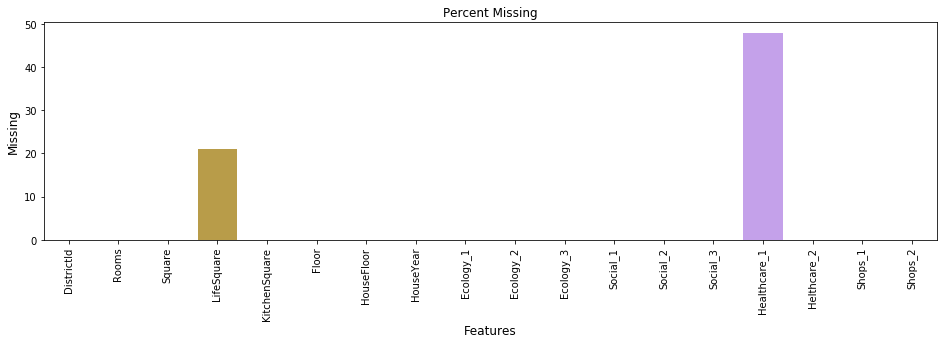

In [410]:
nan_df = (100*(X.isna().sum()) / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Удалим параметр "Healthcare" ввиду большого количества пропусков.

## 2.3 Очистка данных

In [411]:
class FeatureImputer:
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1 # значения "0" заменим на "1"
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # заполнение выброса по количеству комнта от шести медианным значением
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3 # принимаем минимальную площадь кухни за 5^2 метра
        X.loc[X['KitchenSquare'] > 20, 'KitchenSquare'] = 20  # примем максимальную площадь кухни за 20^2 метров
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year # замена значений года постройки выше текущей даты на значение текущей даты
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True) # уберем данный показатель из расчетов
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 5
        
        
        return X

In [412]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)


## 2.4 Генерация фич

In [413]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50] 
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if Y is not None:
            df['Price'] = Y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if Y is not None:
            df['Price'] = Y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
          
    
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  
        X = self.year_to_cat(X)  
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1932, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1932) & (X['HouseYear'] <= 1948), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1948) & (X['HouseYear'] <= 1961), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1961) & (X['HouseYear'] <= 1973), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 1973) & (X['HouseYear'] <= 1985), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 1985) & (X['HouseYear'] <= 1997), 'year_cat'] = 6
        X.loc[(X['HouseYear'] > 1997) & (X['HouseYear'] <= 2009), 'year_cat'] = 6
        X.loc[(X['HouseYear'] > 2009), 'year_cat'] = 7
            
        return X
            
    

In [414]:
features = FeatureGenetator()

features.fit(X, Y)

X = features.transform(X)
X_final = features.transform(X_final)


In [415]:
X.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,1,0,0,0,5.0,1,3.0,4.0,NaN,192865.483385
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,1,...,1,0,0,0,87.0,0,3.0,5.0,300009.450063,177686.959664
2,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,1,...,1,0,0,0,174.0,0,3.0,4.0,263206.223152,192865.483385
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,1,...,1,0,0,0,179.0,0,3.0,5.0,166809.665642,177686.959664
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,1,...,1,0,0,0,97.0,0,4.0,5.0,158539.052715,182353.072029
5,59,3.0,80.384479,46.683720,12.0,5.0,17.0,2011,0.309479,1,...,1,0,0,0,67.0,0,2.0,7.0,466753.618497,155152.086566
6,154,2.0,62.254114,37.160377,7.0,3.0,5.0,1960,0.460556,1,...,1,0,0,0,5.0,1,2.0,3.0,NaN,201000.801581
7,74,2.0,80.312926,72.312926,3.0,13.0,13.0,1977,0.075779,1,...,1,1,0,1,114.0,0,4.0,5.0,243031.695525,182353.072029
8,1,2.0,64.511437,56.511437,3.0,9.0,17.0,1977,0.007122,1,...,1,0,0,1,652.0,0,3.0,5.0,202666.310126,177686.959664
9,23,1.0,46.461409,18.915552,8.0,13.0,17.0,2014,0.075779,1,...,1,0,0,0,565.0,0,4.0,7.0,102069.270740,171854.583922


In [416]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'HouseFloor', 'HouseYear',
                  'DistrictId_count',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear']

X = X[remain_features]
X_final = X_final[remain_features]

# 3. Модель

In [417]:
model = LGBMRegressor('gbdt', 
                              max_depth=6,
                             min_samples_leaf=2,
                             n_estimators=200,
                             random_state=42)

cv_score = cross_val_score(model, X, Y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))

mean = cv_score.mean()
std = cv_score.std()

print('Показатель R2: {:.3f} +- {:.3f}'.format(mean, std))

Показатель R2: 0.738 +- 0.020


In [418]:
model.fit(X, Y) # обучение модели

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=2,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

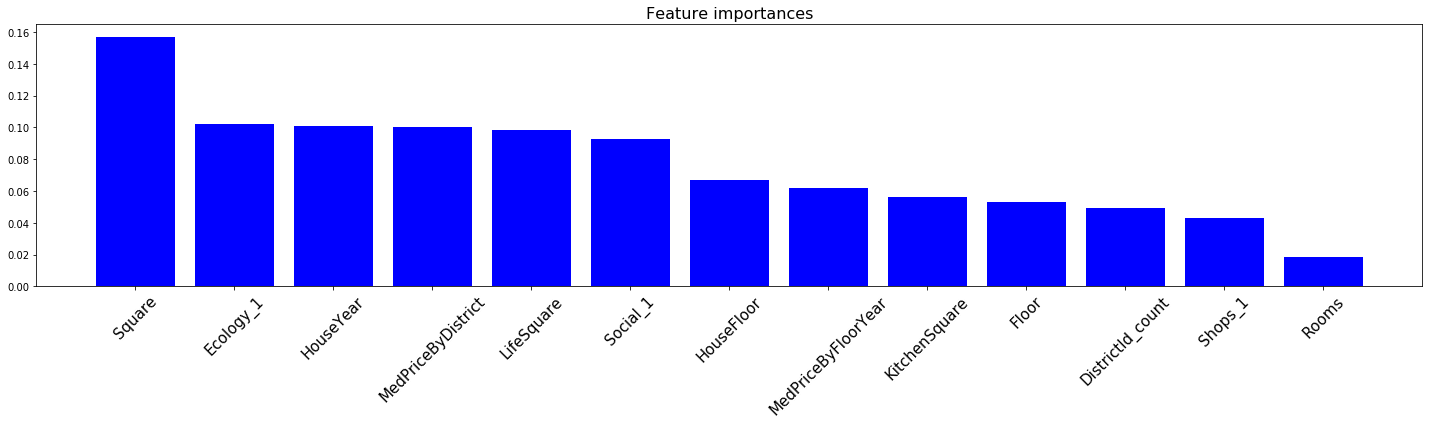

In [419]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="blue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 45, fontsize=15)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [420]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

In [421]:
preds_final.shape

(5000, 2)